In [17]:
from scipy.sparse import diags, kron
from scipy.sparse.linalg import spsolve
import numpy as np
import matplotlib.pyplot as plt

# Define the parameters
N = 10  # Number of grid points (for both x and y)
mu_x = 1.0  # Diffusion coefficient in x direction
mu_y = 1.0  # Diffusion coefficient in y direction
x_start, x_end = 0, 1  # x-range
y_start, y_end = 0, 1  # y-range
source_start, source_end = 0.1, 0.3  # Source term region

# Create grid
x = np.linspace(x_start, x_end, N)
y = np.linspace(y_start, y_end, N)
dx = x[1] - x[0]
dy = y[1] - y[0]

# Define the Laplacian operator in 1D for x and y
Lx = diags([-2*np.ones(N), np.ones(N-1), np.ones(N-1)], [0, -1, 1], shape=(N, N)) * mu_x / dx**2
Ly = diags([-2*np.ones(N), np.ones(N-1), np.ones(N-1)], [0, -1, 1], shape=(N, N)) * mu_y / dy**2

# Define the 2D Laplacian using Kronecker product
L = kron(Lx, diags(np.ones(N))) + kron(diags(np.ones(N)), Ly)

# Create source term
source = np.zeros((N, N))
source[int(N*source_start):int(N*source_end), int(N*source_start):int(N*source_end)] = 1.0
source = -source.flatten()

# Apply boundary conditions (Dirichlet boundary conditions, u = 0 on the boundary)
for i in range(N):
    if i == 0 or i == N-1:
        L[i, :] = 0
        L[i, i] = 1
        source[i] = 0
    L[i*N, :] = 0
    L[i*N, i*N] = 1
    source[i*N] = 0
    L[(i+1)*N-1, :] = 0
    L[(i+1)*N-1, (i+1)*N-1] = 1
    source[(i+1)*N-1] = 0

# Solve the system
u = spsolve(L, source)

# Reshape solution to 2D
u = np.reshape(u, (N, N))


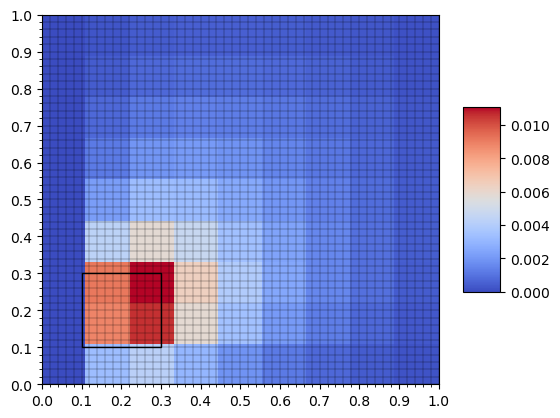

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.patches as patches

fig, ax = plt.subplots()

# Make data.
X = x
Y = y
X, Y = np.meshgrid(X, Y)
Z = u

# Plot the surface.
surf = ax.pcolor(X, Y, Z[:-1,:-1], shading='flat', cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Create a Rectangle patch
rect = patches.Rectangle((0.1, 0.1), 0.2, 0.2, linewidth=1, edgecolor='k', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
hx = 0.1
# Add a grid
plt.grid(which='major', axis='both', linestyle='-', color='k', linewidth=0.2)
plt.minorticks_on()
plt.grid(which='minor', axis='both', linestyle='-', color='k', linewidth=0.2)
major_ticks = np.arange(0., 1.+hx, hx)
minor_ticks = np.arange(0., 1.+hx, hx/5)

plt.xticks(major_ticks)
plt.yticks(major_ticks)
plt.show()

In [19]:
from scipy.sparse.linalg import spilu
from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import cg

# Compute the ILU preconditioner
ilu = spilu(L.tocsc(), drop_tol=0.1)

# Define the matrix-vector product function
M_x = lambda x: ilu.solve(x)
M = LinearOperator((N**2, N**2), M_x)

# Solve the system using the Preconditioned Conjugate Gradient method
u_pc, info = cg(L, source, M=M)

# Check if the solver converged (info should be 0)
if info == 0:
    print("Solver converged.")
else:
    print("Solver failed to converge.")

# Reshape solution to 2D
u_pc = np.reshape(u_pc, (N, N))

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.patches as patches

fig, ax = plt.subplots()

# Make data.
X = x
Y = y
X, Y = np.meshgrid(X, Y)
Z = u_pc

# Plot the surface.
surf = ax.pcolor(X, Y, Z[:-1,:-1], shading='flat', cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Create a Rectangle patch
rect = patches.Rectangle((0.1, 0.1), 0.2, 0.2, linewidth=1, edgecolor='k', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
hx = 0.1
# Add a grid
plt.grid(which='major', axis='both', linestyle='-', color='k', linewidth=0.2)
plt.minorticks_on()
plt.grid(which='minor', axis='both', linestyle='-', color='k', linewidth=0.2)
major_ticks = np.arange(0., 1.+hx, hx)
minor_ticks = np.arange(0., 1.+hx, hx/5)

plt.xticks(major_ticks)
plt.yticks(major_ticks)
plt.show()

RuntimeError: Factor is exactly singular